In [59]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [60]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

In [61]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    
price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 100
Total trading days: 1022


Analyzing pairs: 100%|██████████| 4950/4950 [01:20<00:00, 61.71it/s]



Analysis complete!
Found 497 cointegrated pairs
Total pairs analyzed: 4950


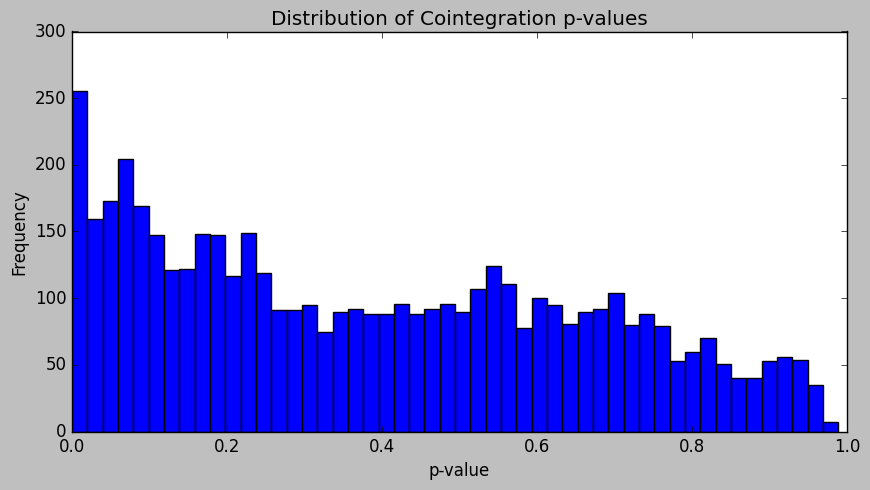

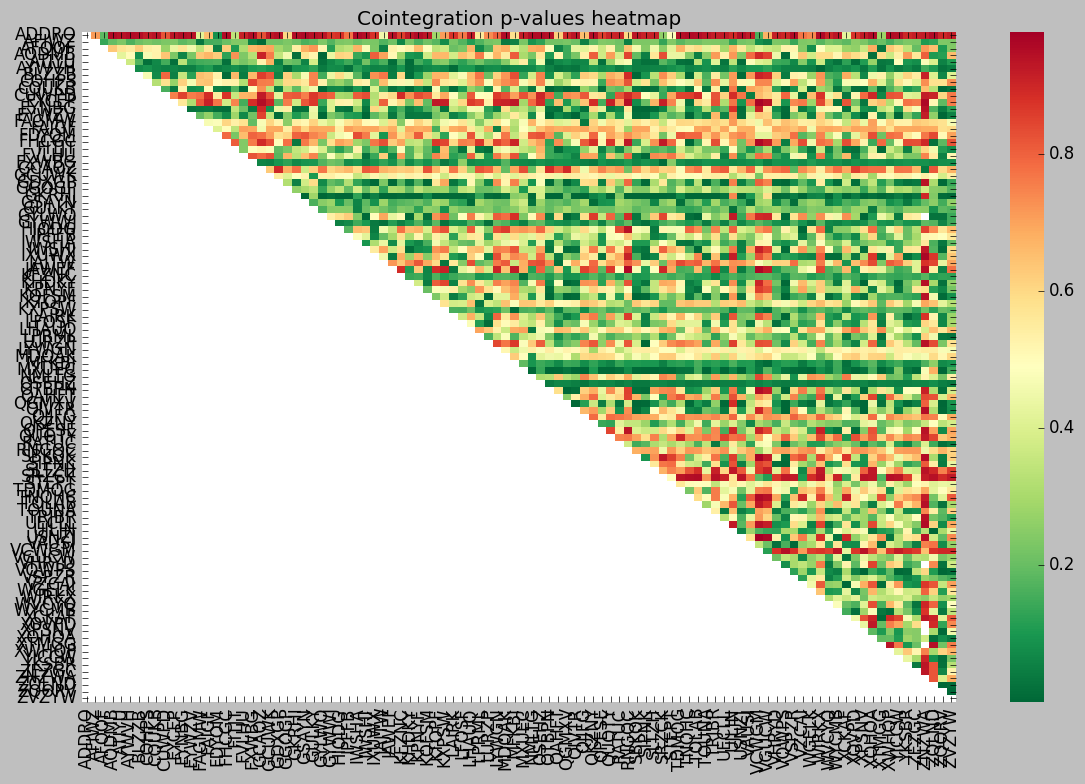

In [62]:
score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(
    price_matrix,
    pvalue_threshold=0.05
)

plt.figure(figsize=(10, 5))
plt.hist(summary_df['p_value'], bins=50)
plt.title('Distribution of Cointegration p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

plot_cointegration_heatmap(pvalue_matrix, symbols)

In [63]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    # Calculate ratio and z-score
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window1=5, window2=60):
    ratios_train = S1_train / S2_train
    ma2_train = ratios_train.rolling(window=window2, center=False).mean()
    std_train = ratios_train.rolling(window=window2, center=False).std()
    
    ratios_test = S1_test / S2_test
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    for i in range(len(ratios_test)):
        current_ratio = ratios_test.iloc[i]
        current_date = ratios_test.index[i]
        
        ma2_test = ratios_test.iloc[:i+1].rolling(window=window2, center=False).mean().iloc[-1]
        std_test = ratios_test.iloc[:i+1].rolling(window=window2, center=False).std().iloc[-1]
        zscore = (current_ratio - ma2_test) / std_test
        
        if position == 0:
            if zscore > 1.0:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "short"},
                    symbol2: {"price": S2_test.iloc[i], "type": "long"}
                }
                position = -1
                
            elif zscore < -1.0:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "long"},
                    symbol2: {"price": S2_test.iloc[i], "type": "short"}
                }
                position = 1
                
        elif abs(zscore) < 0.5 and position != 0:
            for symbol in [symbol1, symbol2]:
                trades.append({
                    'trade_id': trade_id,
                    'symbol': symbol,
                    'entry_date': entry_date,
                    'entry_price': entry_prices[symbol]["price"],
                    'exit_date': current_date,
                    'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                    'position_type': entry_prices[symbol]["type"],
                    'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                    'exit_type': 'target'
                })
            position = 0
            trade_id += 1
            
    return trades

def backtest_pairs(price_matrix, pairs, train_end_date):
    all_trades = []
    
    for symbol1, symbol2 in pairs:
        training_mask = price_matrix.index < train_end_date
        
        S1_train = price_matrix[symbol1][training_mask]
        S2_train = price_matrix[symbol2][training_mask]
        S1_test = price_matrix[symbol1][~training_mask]
        S2_test = price_matrix[symbol2][~training_mask]
        
        pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
        all_trades.extend(pair_trades)
    
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('../../data/results/CoInt_Z-Score.parquet')
    
    return trades_df

In [64]:
combined_scores = []
symbols = price_matrix.columns.tolist()  

for pair in pairs:
    idx1 = symbols.index(pair[0])
    idx2 = symbols.index(pair[1])
    
    sum_idx = summary_df[(summary_df['symbol1'] == pair[0]) & (summary_df['symbol2'] == pair[1])].index[0]
    
    score_value = score_matrix[idx1, idx2]
    p_value = summary_df.loc[sum_idx, 'p_value']
    
    combined_scores.append({
        'pair': pair,
        'score': -score_value * (1 - p_value)
    })

sorted_pairs = sorted(combined_scores, key=lambda x: x['score'], reverse=True)
top_20_pairs = [x['pair'] for x in sorted_pairs[:20]]


In [65]:
trades_df = backtest_pairs(price_matrix, top_20_pairs, DATE_CONFIG['TRAIN_END'])

In [66]:
print("Gefundene Pairs:")
for pair in top_20_pairs:
    print(f"{pair[0]} - {pair[1]}")
print(f"\nGesamtanzahl der Pairs: {len(pairs)}")

Gefundene Pairs:
GYLWO - XPSNV
GKRHI - TOLAB
GKRHI - GYLWO
GKRHI - USNZJ
GKRHI - IWSHI
BLZZB - TNQHC
CQUKB - KHDKY
GKRHI - KPNYF
QIVTR - VQWPS
GKRHI - TNQHC
MXUEC - WGELK
QGMXV - VQWPS
GKRHI - SBKOK
GKRHI - QAHFT
GKRHI - IPFFB
GDXGP - QGMXV
GKRHI - SIPNK
EYWZV - GYLWO
CQUKB - KQFSM
ZQORV - ZVZYW

Gesamtanzahl der Pairs: 497
